<a href="https://colab.research.google.com/github/05-515/stepik_deep_learning_2024_1/blob/main/5_2_%5Bseminar%2C_unsolved%5Dregularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Регуляризация в линейных алгоритмах</b></h1>

В этом семинаре мы поговорим об $L_1$- и $L_2$-регуляризации линейной регрессии, а также об ElasticNet. Реализуем линейную регресиию с Lasso-регуляризацией и сравним реализацию с моделью из sklearn.

Зачастую модель машинного обучения обучается на зашумлённых данных, то есть данных с ошибками и случайными отклонениями. Модель машинного обучения, которая обучается на минимизацию функции потерь, не может автоматически понять, где в датасете реальные важные закономерности, а где -- ошибки и случайные совпадения. Нам бы хотелось заставить модель **не переобучаться** под такие проблемы в данных и вычленять только неслучаные закономерности. Иначе, идеально обучившись на датасете с шумом, мы можем получить плохой результат на тестовых данных.

На практике переобучение проявляется в излишней сложности модели. **Регуляризация** -- это метод борьбы с переобучением, который штрафует модель за излишнюю сложность сложность, что позволяет строить более простые (и потому стабильные) зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**. Как разбиралось на лекции, если оптимальных решений задачи минимизации оказывается бесконечно много, то коэффициенты модели могут принимать какие угодно огромные значения. **Вывод**: необходимо *ограничить величину* коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации.

Функция потерь для линейной регрессии с регуляризацией выглядит следующим образом:
$$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\langle \mathbf{w} , x^i \rangle - y^i)^2 + R(\tilde{ \mathbf{w}}) \rightarrow \min_{w}$$
где
* $x^i = (1, x^i_1, \ldots, x^i_n)$ --- вектор признаков $i$-ого объекта;
* $y^i \in\mathbb{R}$ --- правильный ответ на $i$-ом объекте;
* $\mathbf{w} = (w_0, w_1, \ldots, w_n)$ --- вектор весов ($w_0$ --- свободный член).
* $\tilde {\mathbf{w}} =  (w_1, \ldots, w_n)$ --- вектор весов без свободного члена.

Последнее слагаемое определяет вид регуляризации.
* $L_1$-регуляризация (LASSO, least absolute shrinkage and selection operator), регуляризационное слагаемое равно $$R( \mathbf{\tilde w}) = \lambda|| \mathbf{\tilde {w}}||_1 = \lambda (|w_1| + \ldots + |w_n|);$$
* $L_2$-регуляризация (Ridge), регуляризационное слагаемое равно $$R(\tilde{ \mathbf{w}}) = \lambda||\tilde{ \mathbf{w}}||_2^2 = \lambda(|w_1|^2 + \ldots + |w_n|^2);$$
* ElasticNet -- комбинация двух предыдущих, регуляризационное слагаемое равно $$R(\tilde{ \mathbf{w}}) = \alpha ||\tilde{\mathbf{w}}||_1+ \beta ||\tilde {\mathbf{w}}||_2^2.$$

Обратите внимание, что во всех случаях **коэффициент $w_0$ не участвует в сумме!**


In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Lasso-регрессия

В LASSO-регрессии мы штрафуем модель **на сумму модулей всех ее весов**.

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell} ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda ||\tilde{\mathbf{w}}||_1,$$ где $\lambda$ -- гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}|w_j|$$



**Градиент:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \frac{2}{\ell}\cdot X^T(X\mathbf{w} - \mathbf{y}) + \lambda (0, \mathrm{sign}(w_1), \ldots, \mathrm{sign}(w_n))^T.
$$

Будем считать, что $|\cdot|$ -- дифференцируемая функция, ее производной является $sign(\cdot)$.


In [ ]:
def soft_sign(x, eps=1e-7):# eps задаем как 10 в минус 7. если х больше то его знак возвращаем. если меньше,то число,ояень близкое к 0
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)


class MyLassoRegression(object):
    def __init__(self, C=1):
        self.coef_ = None #все переменные, кроме свободного члена
        self.intercept_ = None # свободный член. делаем отлельно, т.к.в моделях с регуляризацией сободный член особенно может отличаться от остальных. может быть каким угодно.а остальные веса будем штрафовать за сложность
        self.C = C # константа регуляризации, лямбда

    def regularization_term(self, weights):
        signs = np_soft_sign(weights) # YOUR CODE. Calculate soft signs of weights  # [n+1, 1]
        signs[0] = 0  # Не нужно регуляризовывать по свободному члену
        return signs

    def grad(self, X, y, weights):
        y_pred = (X @ weights)  # [l, 1]

        basic_term =  (2. / X.shape[0]) * (X.T @ (y_pred - y))  # YOUR CODE. Calulate basic term of loss  # [n+1, 1]

        regularization_term = self.regularization_term(weights)  # [n+1, 1]

        return basic_term + self.C * regularization_term  # [n+1, 1]


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]

        l, n = X.shape

        # Добавляем признак из единиц
        X_train = np.hstack([np.ones([l, 1]), X])  # [ell, n + 1]

        # Инициализируем веса
        weights = np.random.randn(n + 1, 1)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            grad = self.grad(X_train, y, weights)
            # update weights
            weights -= grad * lr / ((iter_num + 1) ** 0.5) #для того,чтобы с каждой итерацией learning rate уменьшался

            # calculate loss
            loss = np.mean((X_train @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_ #не добавляем вектор столбец из единиц

        return y_pred

Протестируем нашу функцию на одномерной регрессии.

In [ ]:
def linear_expression(x):
    return 5 * x + 6

In [ ]:
from sklearn.model_selection import train_test_split

objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

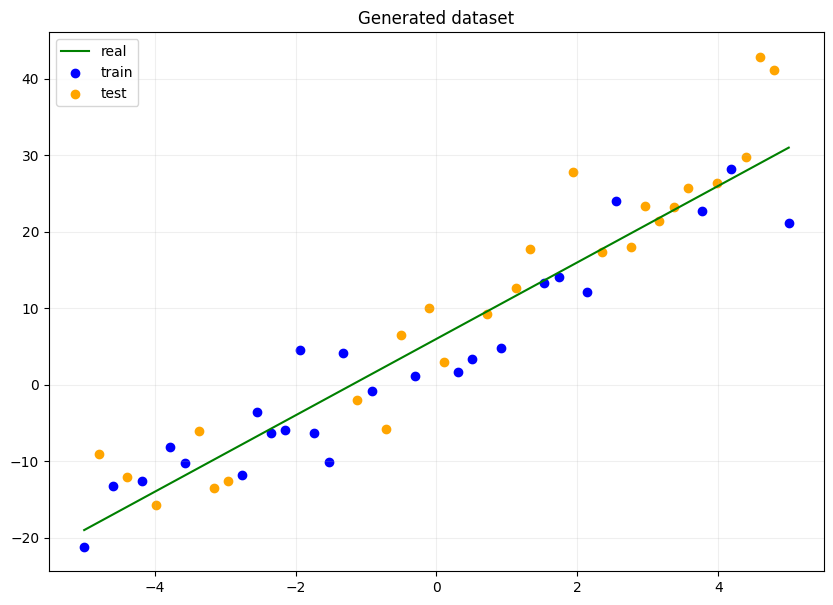

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [ ]:
regressor = MyLassoRegression()

losses = regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])

In [ ]:
regressor.coef_, regressor.intercept_

(array([[4.35027325]]), array([4.4657142]))

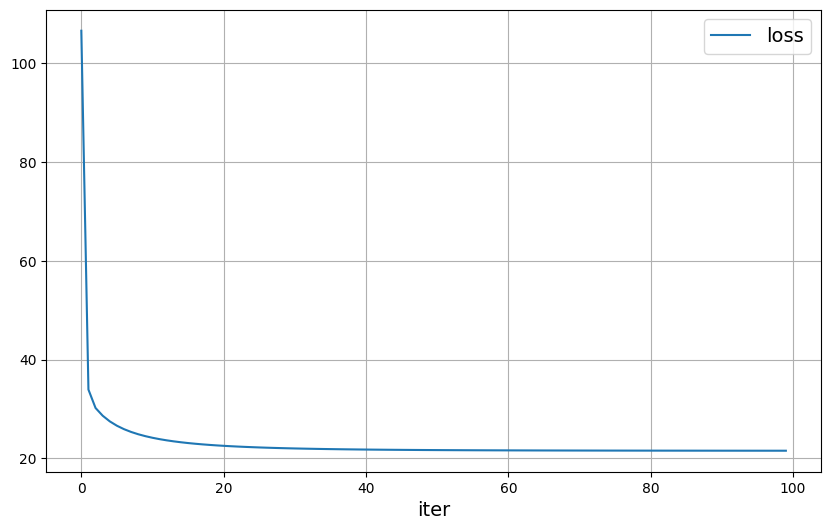

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

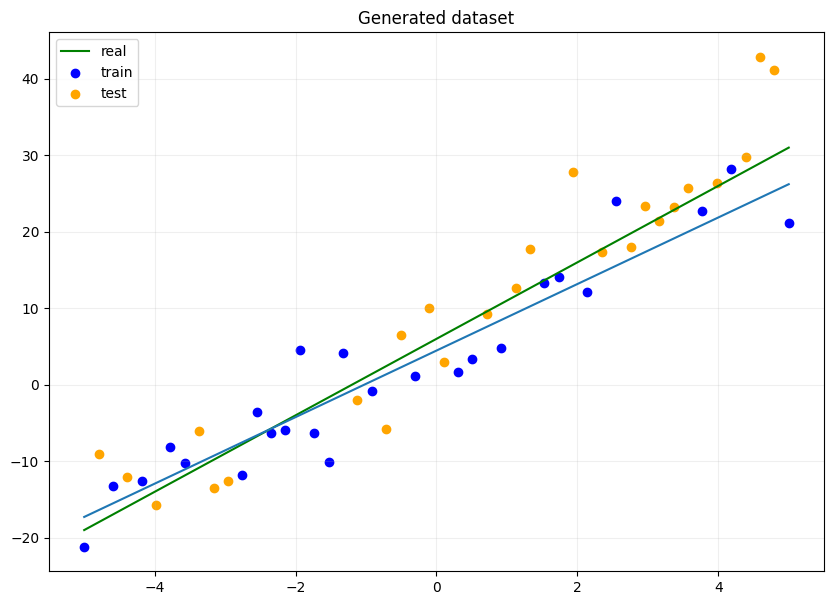

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.plot(X, regressor.predict(X[:, np.newaxis]))

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

## Загрузка датасета
Загрузим набор данных, с которым мы будем работать. В библиотеке scikit-learn есть множество тренировочных наборов данных для освоения и проверки методов машинного обучения. Мы будем работать с датасетом Diabetes. Этот датасет содержит данные о развитии диабета у пациента. Всего в датасете 10 признаков.

<img src="https://drive.google.com/uc?id=19oN1ydcPobFRKc6Bx6Bf8tLVmI4Kh4g4" width="400">

Стандартные наборы данных в scikit-learn находятся в модуле sklearn.datasets.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

In [ ]:
data = load_diabetes()

print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

### Выделение данных

Выделим матрицу объекты-признаки в переменную $X$, правильные ответы --- в переменную $y$. Используем библиотеку pandas. Для отображения информации о наборе данных используем функцию pd.describe, которая отображает полезные статистики из набора: средние значения признаков, минимум, максимум, медиану и др.

In [ ]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
from sklearn.preprocessing import StandardScaler #сделаем нормировку признаков. при регуляризации очень важны масштабы признаков.
#как масштабируем. у каждого признака среднее значение должно быть равно 0, а среднее отклонение 1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) # YOUR CODE. Fit and apply scaler
X_test_scaled =  scaler.transform(X_test)# YOUR CODE. Apply scaler

In [ ]:
# YOUR CODE. Verify that scaler worked OK
np.mean(X_train_scaled, axis=0)
np.std(X_train_scaled, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
model = MyLassoRegression(C=0.001) #выбираем небольшой коэффициент,чтобы соблюсти баланс для алгоритма
losses = model.fit(X_train_scaled, y_train)

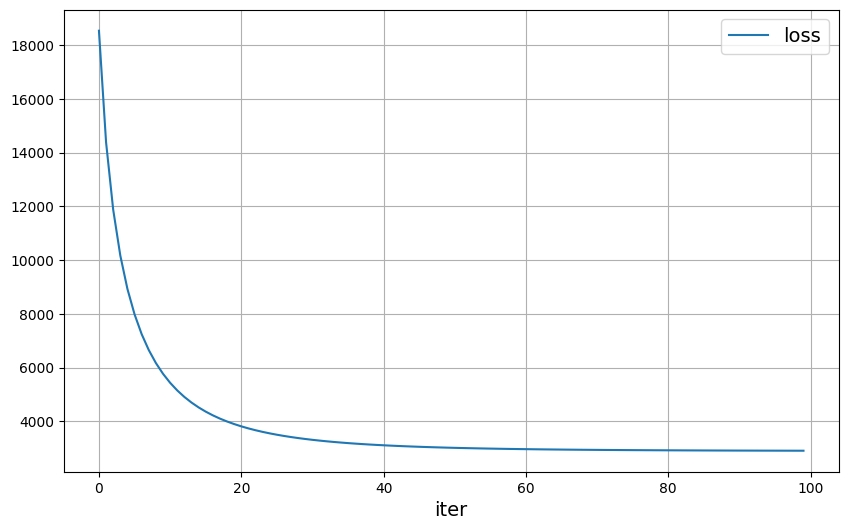

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

<BarContainer object of 10 artists>

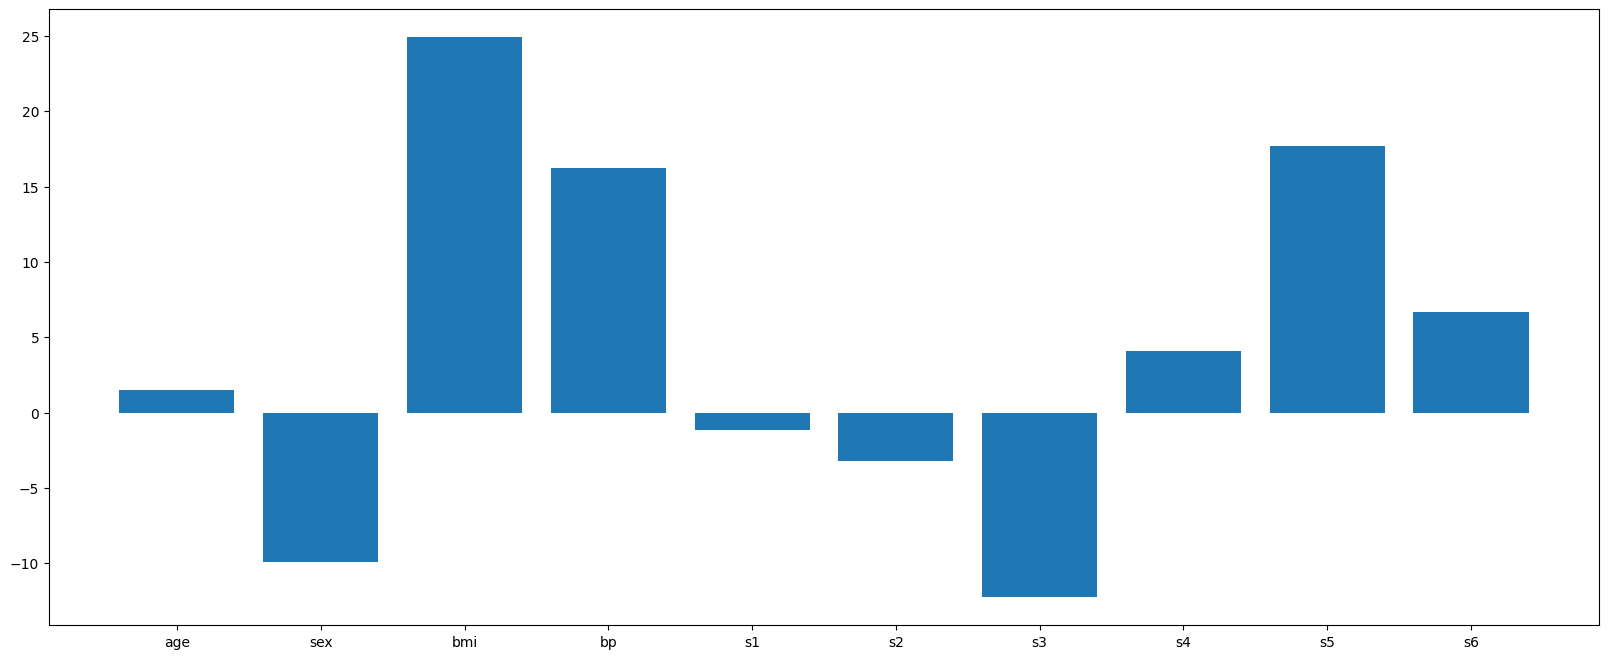

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_.ravel())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_train_prediction = model.predict(X_train_scaled)
y_test_prediction = model.predict(X_test_scaled)

print(f'Train MSE: {mean_squared_error(y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_prediction)}')

Train MSE: 2908.857800951135
Test MSE: 2963.6601499795293


In [ ]:
model.coef_, model.intercept_

(array([[  1.51849615],
        [ -9.89032862],
        [ 24.91028449],
        [ 16.25773073],
        [ -1.1584083 ],
        [ -3.20963579],
        [-12.25922321],
        [  4.09353191],
        [ 17.66967906],
        [  6.7060664 ]]),
 array([149.84271319]))

## Величина весов в зависимости от коэффициента регуляризации

In [ ]:
#проведем эксперимент. по оси X коэф регуляр, по y коэф,которые при обучении получаются
reg_coefs = np.linspace(10, 100, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = MyLassoRegression(C=C)
    lasso_regressor.fit(X_train_scaled, y_train, lr=0.05, max_iter=5000)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

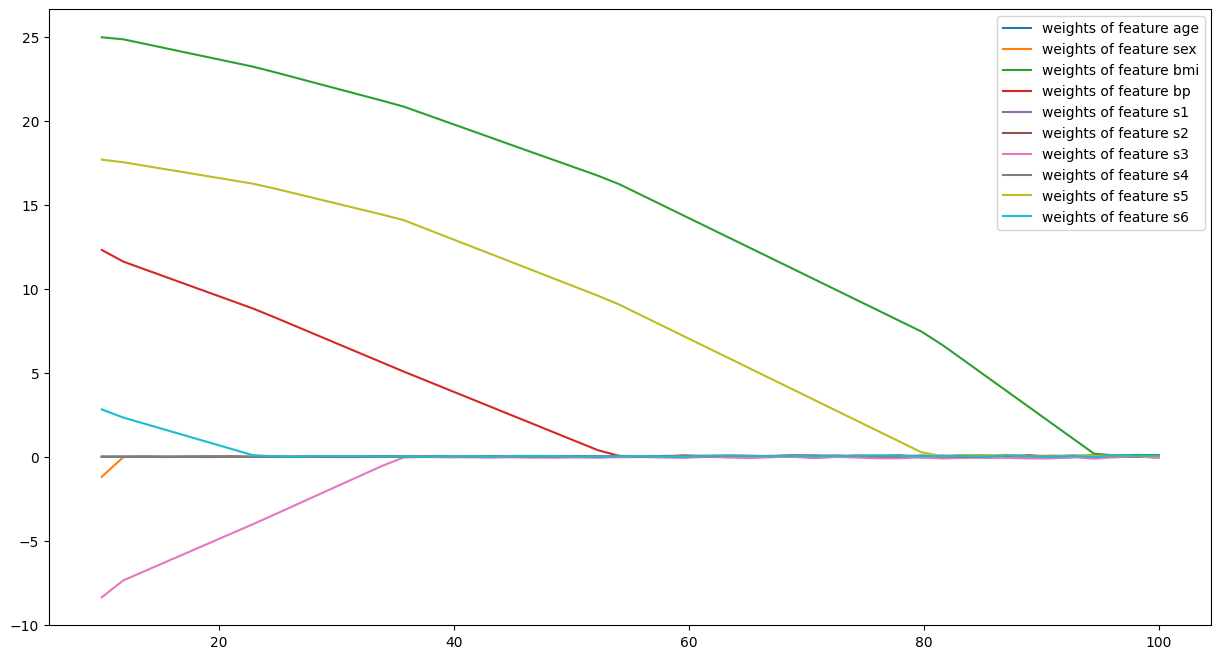

In [ ]:
# при с =10 все признаки не нули,при увеличении  с признаки зануляются. чем больше с,тем меньше признаков остается.оптимальная с в начале
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

Построим такие же графики для реализации из sklearn:

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
reg_coefs = np.linspace(5, 50, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = Lasso(alpha=C)# вместо своего класса используем Lasso
    lasso_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

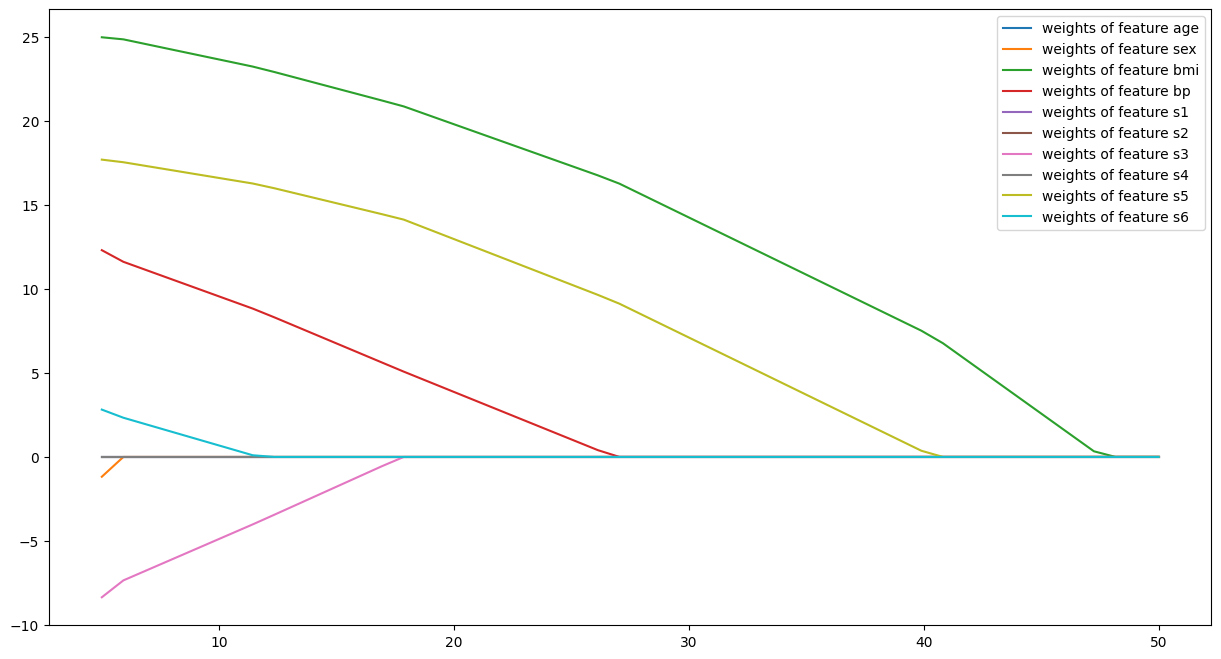

In [ ]:
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

# 2.1. Ridge регрессия (L2-регуляризация)

В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:**
$$L(\mathbf{w}) = ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda||\mathbf{\tilde{w}}||^2_2 = \sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}w_j^2,$$
где $\lambda$ --- гиперпараметр, отвечающий за степень регуляризации.

Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

Сравнение с графиками для Ridge-регрессии:

In [ ]:
from sklearn.linear_model import Ridge

reg_coefs = np.linspace(1, 10000, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    ridge_regressor = Ridge(C)
    ridge_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))

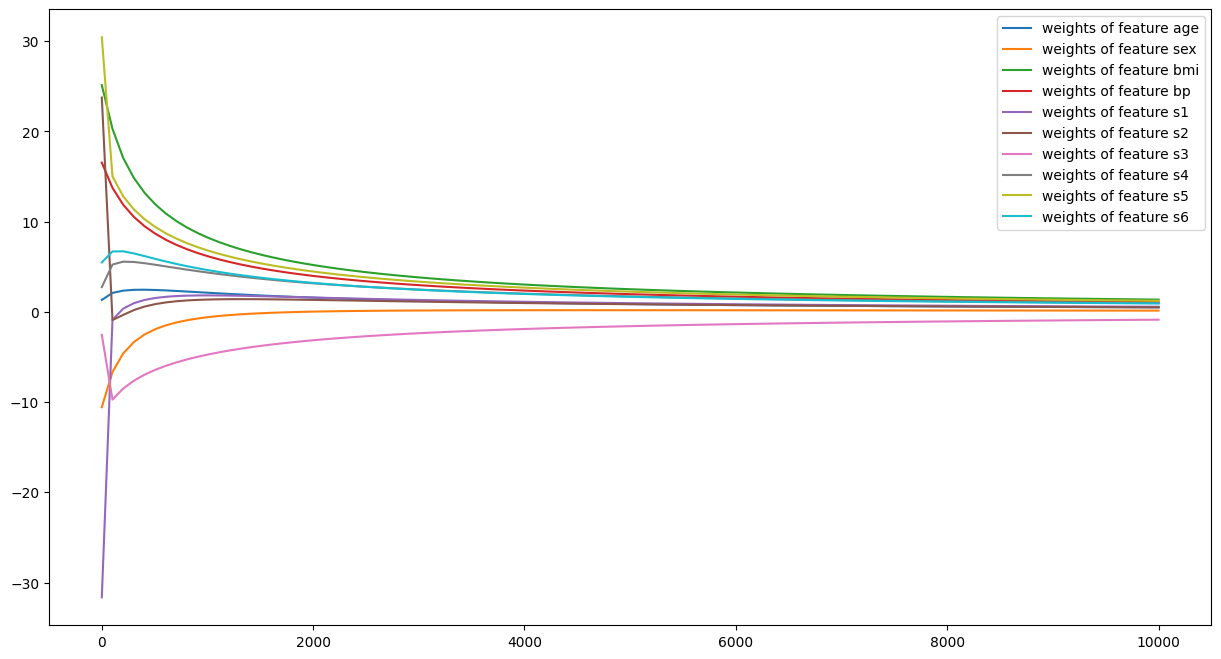

In [ ]:
# при L1 регуляризации веса по очереди занулялись. для L2 графики более гладкие. для отбора признаков брать нельзя.более универсальная. если нет цели отбирать признаки, то ее можно не использовать
# по-умолчанию в scilrnt стоит l2 регуляризация. l1 сложнее обучать и есть эффект зануления весов
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

Различия между $L_1$- и $L_2$-регуляризациями:

- Lasso **сложнее обучать** из-за отсутствия аналитического решения
- В Lasso появляется **зануление весов** для некоторых признаков

## Для самостоятельного изучения: реализация Ridge-регрессии

Аналогично предыдущим заданиям нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{\mathbf{w}}}$.

**Градиент:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \frac{2}{\ell}\cdot X^T(X\mathbf{w} - \mathbf{y}) + 2\lambda \cdot (0, w_1, \ldots, w_n)^T.
$$


In [ ]:
class MyRidgeRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def regularization_term(self, weights):
        outp = 2 * weights.copy()
        outp[0] = 0  # Не нужно регуляризовывать по свободному члену
        return outp

    def grad(self, X, y, weights):
        y_pred = (X @ weights)  # [ell, 1]

        basic_term = 2. / X.shape[0] * (X.T @ (y_pred - y))

        regularization_term = self.regularization_term(weights)

        return basic_term + self.C * regularization_term


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]

        l, n = X.shape

        # Добавляем признак из единиц
        X_train = np.hstack([np.ones([l, 1]), X])  # [l, n+1]

        # Инициализируем веса
        weights = np.random.randn(n+1, 1)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            grad = self.grad(X_train, y, weights)
            # update weights
            weights -= grad * lr / ((iter_num + 1) ** 0.5)

            # calculate loss
            loss = np.mean((X_train @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred